In [1]:
%matplotlib inline

# All TEMCA optical image processing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import boto3
import skimage.io as io
import skimage
from skimage import data
from skimage import feature
from skimage import color
from skimage import filters
from skimage import transform 
from skimage import draw
from skimage import measure
from skimage import morphology
import skdemo
from scipy import ndimage as ndi
from toolbox.TAO.tao import TAO
from toolbox.TAO.taoDB import TAOdb

In [3]:
taoDB = TAOdb()

In [4]:
ai = {
    'imfull': None, # the complete image, including barcode
    'imbarcode': None, # just the barcode
    'imrgb': None, # cropped image
    'imgray': None, # grayscale version of cropped
    'imhsv': None, # hsv version of cropped
    'im_mask_aperture': None, # mask of aperture
    'im_mask_tissue': None, # mask of tissue
    'im_mask_film': None, # mask of film
    'crop_offset': {'x': 100, 'y': 300}
}

In [5]:
def create_all_images(specimen, media, barcode, ai):
    ''' create all of the formats used in later processing'''
    url = taoDB.get_aperture_image_url(specimen, media, barcode)
    ai['imfull'] = io.imread(url)
    # crop off the barcode
    ai['imrgb'] = ai['imfull'][ai['crop_offset']['y']:, ai['crop_offset']['x']:, :]
    ai['imhsv'] = color.rgb2hsv(ai['imrgb'])
    ai['imgray'] = color.rgb2gray(ai['imrgb'])

In [6]:
def create_aperture_mask(ai):
    ''' create a mask which contains the complete aperture as foreground'''
    # threshold
    threshold = filters.threshold_otsu(ai['imgray'])
    imb = ai['imgray'] <= threshold

    # label it
    imlabel = morphology.label(imb)

    # remove small blobs
    imnosmall = morphology.remove_small_objects(imlabel, min_size=4000, connectivity=1, in_place=False)

    # fill small holes
    imnosmall = morphology.remove_small_holes(imnosmall, min_size=200, connectivity=2, in_place=False)

    # trim tendrils
    se = morphology.disk(11)
    imnosmall = morphology.opening(imnosmall, se)
    ai['im_mask_aperture'] = imnosmall

In [7]:
def create_tissue_mask(ai):
    ''' create a mask which contains just the tissue as foreground'''
    # get just the hue
    imv = ai['imhsv'][:,:,0]
    threshold = filters.threshold_otsu(imv )
    print threshold
    imb = imv < threshold
    #skdemo.imshow_with_histogram(imb);
    imb = skimage.img_as_int(imb)

    # label it
    imlabel = morphology.label(imb)

    # remove small blobs
    imnosmall = morphology.remove_small_objects(imlabel, min_size=4000, connectivity=1, in_place=False)

    # fill small holes
    imnosmall = morphology.remove_small_holes(imnosmall, min_size=200, connectivity=2, in_place=False)

    # trim tendrils
    se = morphology.disk(5)
    imnosmall = morphology.opening(imnosmall, se)

    # remove small blobs
    imnosmall = morphology.remove_small_objects(imnosmall, min_size=4000, connectivity=1, in_place=False)
    ai['im_mask_tissue'] = imnosmall

In [8]:
def create_film_mask(ai):
    ''' create a mask which contains just the film as foreground'''
    film = np.logical_xor (ai['im_mask_aperture'], ai['im_mask_tissue'])
    se = morphology.disk(5)
    imnosmall = morphology.opening(film, se)
    imnosmall = morphology.remove_small_objects(imnosmall, min_size=4000, connectivity=1, in_place=False)
    ai['im_mask_film'] = imnosmall

In [9]:
def display_one (specimen, media, barcode, ai):
    create_all_images(specimen, media, barcode, ai)
    create_aperture_mask(ai)
    create_tissue_mask(ai)
    create_film_mask(ai)

    fig, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(ncols=4, figsize=(12, 8))
    ax_1.imshow(ai['imrgb'])
    ax_1.set_title('original')
    ax_2.imshow(ai['im_mask_aperture'])
    ax_2.set_title('aperture')
    ax_3.imshow(ai['im_mask_film'])
    ax_3.set_title('film')
    ax_4.imshow(ai['im_mask_tissue'])
    ax_4.set_title('tissue')
    plt.show()

0.350569661458


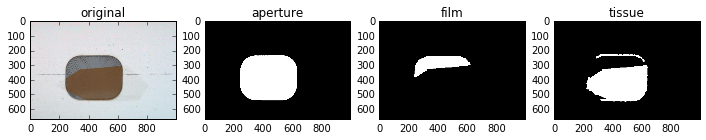

0.370655548878


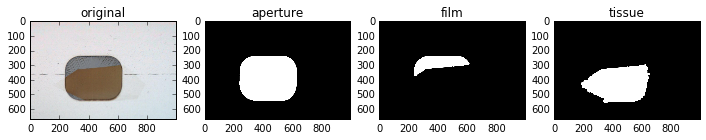

0.370655548878


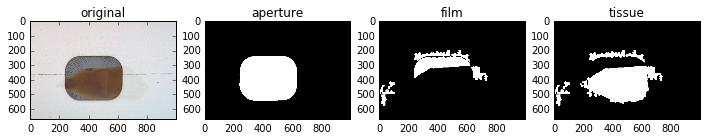

0.331843449519


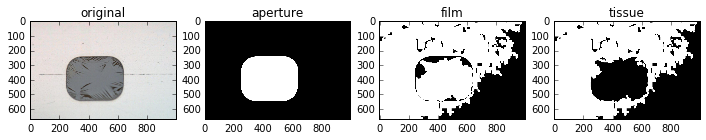

0.350569661458


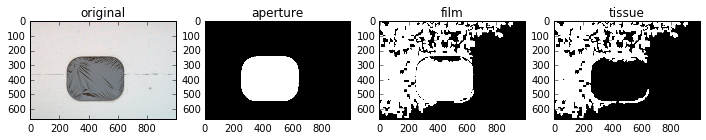

In [13]:
for j in range (940, 945):
    display_one('239849_7R', '1', str(j).zfill(6), ai)